# Beginning to explore the [dataset](https://www.kaggle.com/datasets/awsaf49/brats2020-training-data/data)

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import h5py
%matplotlib inline

The data comes in the form of h5 files. For each volume, a different patient's brain is represented in the form of 155 2D slices. These slices together compose a 3D rendering of the brain. There are 4 modalities for each volume as well: T1, T1Gd, T2, and FLAIR.

T1-
* High-resolution structural images of the brain
* Differences in tissue types (gray, white, csf)
* Useful for brain anatomy
* Gray matter appears gray, white matter appears white, and cerebrospinal fluid (CSF) appears dark. Tumors can sometimes appear as bright spots, but other modalities provide more detailed tumor information.

T1Gd-
* T1 repeated after injecting a constrast agent which enhances abnormalities (tumors included)
* Helps identify tumors which show up much brighter from contrast
* Tumors or abnormal tissue show up much brighter compared to normal tissue, making it easier to identify and delineate tumors, especially when they have leaky blood vessels.

T2-
* Captures fluid content in tissues
* Provides contrast around edema (swelling) around tumor or cyst
* CSF appears very bright, and white matter appears darker compared to T1-weighted images. Tumors might appear as areas of high intensity depending on the type of tumor.

FLAIR-
* Special T2 designed to suppress noise from CSF
* Easier to see lesions near ventricles or areas with a lot of fluid
* The CSF appears dark, and tumors or lesions appear as bright spots due to the high water content. This makes FLAIR especially good at detecting tumors that are near the brain’s fluid-filled regions.


In [2]:
images = []
masks = []
for i in range(155):
    file_path = f'../data/raw/Brats2020/BraTS2020_training_data/content/data/volume_1_slice_{i}.h5'
    with h5py.File(file_path, 'r') as f:
        print("Keys in file:", list(f.keys()))
        image_data = f["image"][:]
        mask_data = f["mask"][:]
        

        images.append(image_data)
        masks.append(mask_data)


images = np.array(images)
masks = np.array(masks)
print("shape of image:", images.shape)
print("shape of mask:", masks.shape)

Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in file: ['image', 'mask']
Keys in 

Image being (240, 240, 4) means 240x240 pixel 2D images for each modality.

Mask being (240, 240, 3) means there are likely 3 channels to segment into: background, tumor-core, enhancing tumor.

Text(0.5, 1.0, 'Segmentation Mask')

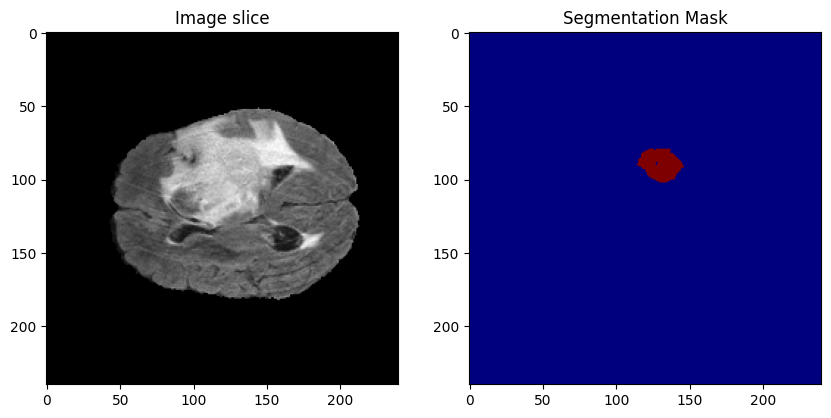

In [3]:
slice_index = 77

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(images[slice_index, :, :, 0], cmap='grey')
plt.title("Image slice")

plt.subplot(1, 2, 2)
plt.imshow(masks[slice_index, :, :, 2], cmap='jet')
plt.title("Segmentation Mask")


In [4]:
# make sure all image values are represented by float32 for numerical stability
images = images.astype(np.float32)

# establish the percentiles per channel (channel is axis 3)
p_low = np.percentile(images, 1, axis=(0, 1, 2), keepdims=True)
p_high = np.percentile(images, 99, axis=(0, 1, 2), keepdims=True)

# truncate all values of images to the low and high percentiles to get rid of outliers
images = np.clip(images, p_low, p_high)
images = (images - p_low) / (p_high - p_low)


In [5]:
from torchvision.transforms import v2
import torch

In [6]:
# Permute the array to (N, C, H, W) format where N=155, C=4 (modalities), H=240, W=240
tensor_images = torch.from_numpy(images).permute(0, 3, 1, 2)

In [7]:
transform = v2.RandomCrop(size=(100, 100))
random_crop = transform(tensor_images)

Text(0.5, 1.0, 'Segmentation Mask')

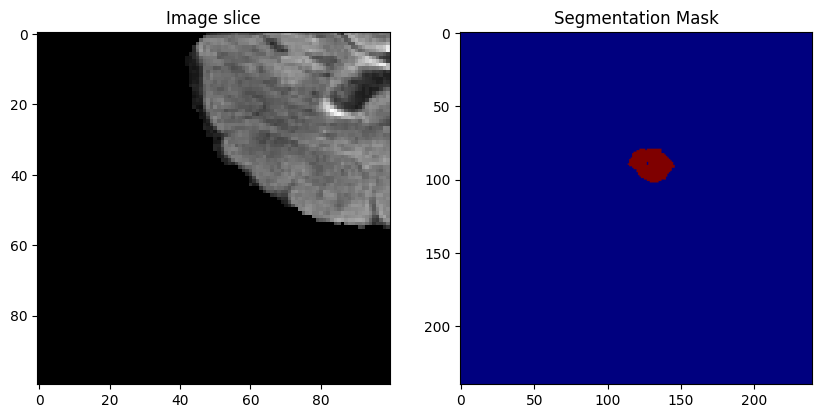

In [8]:
slice_index = 77

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(random_crop[slice_index, 0, :, :], cmap='grey')
plt.title("Image slice")

plt.subplot(1, 2, 2)
plt.imshow(masks[slice_index, :, :, 2], cmap='jet')
plt.title("Segmentation Mask")


In [9]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(150, 150), antialias=True),
    v2.RandomHorizontalFlip(p=0.25),
    v2.RandomVerticalFlip(p=0.25),
    v2.RandomRotation(90),
    v2.ToDtype(torch.float32)
])

augmented_images = transforms(tensor_images)

Text(0.5, 1.0, 'Segmentation Mask')

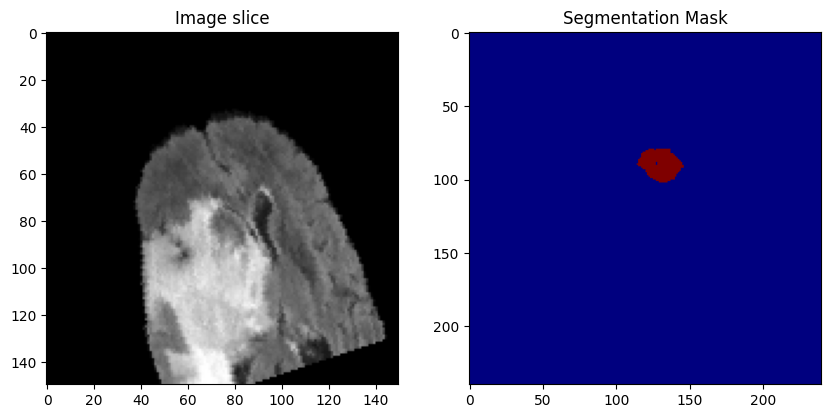

In [10]:
slice_index = 77

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(augmented_images[slice_index, 0, :, :], cmap='grey')
plt.title("Image slice")

plt.subplot(1, 2, 2)
plt.imshow(masks[slice_index, :, :, 2], cmap='jet')
plt.title("Segmentation Mask")


In [11]:
import sys
import os

In [12]:
sys.path.append(os.path.abspath("../src"))

In [13]:
from data_loader import preprocess_data

In [ ]:
augmented_images, masks = preprocess_data()